# Simple speech recognition

Audio 데이터를 다뤄서 학습하는 방법을 배워보도록 합시다.
머신러닝 작업과정은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.

In [ ]:
!nvidia-smi

Tue Jan  2 03:43:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Project 설명
### Task
* 1초 길이의 오디오 음성데이터를 이용해 단어를 분류하는 것이 목표입니다.
* 주어진 데이터를 이용해 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* This code is borrowed from [Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).
* This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.

### Baseline
* ResNet 구조와 유사한 skip connection 구조를 구현해 보자.
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
* Training
    * tf.data.dataset과 model.fit()을 사용

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import matplotlib.pyplot as plt

import os
from os.path import isdir, join

import random
import copy
import sys

tf.__version__

'2.15.0'

### Import modules

* Colab 적용을 위한 변수 지정 및 드라이브 마운트

In [ ]:
use_colab = True
assert use_colab in [True, False]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load dataset
* 사용할 데이터셋을 살펴봅시다.

In [ ]:
if use_colab:
    DATASET_PATH = "/content/drive/MyDrive/dataset/wave_cls"
else:
    DATASET_PATH = "./"

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

In [ ]:
# npz 파일은 npy 파일들을 압축한 파일입니다.
speech_data = np.load(os.path.join(DATASET_PATH, "speech_wav_8000.npz"))

* npz 형태의 파일은 npy의 압축형태이며, files 이름 내에 데이터를 저장하고 불러올 수 있습니다.
* files를 출력하면, 데이터가 어떤 key값으로 저장되어 있는지 확인할 수 있습니다!

In [ ]:
# files를 입력해보시면, 압축된 파일(npy)들의 종류를 확인할 수 있습니다.
print(speech_data.files)

['wav_vals', 'label_vals']


* 각 데이터가 어떤 형태로 저장되어 있는지 확인해봅시다.

In [ ]:
# 불러온 데이터들의 모양
print(speech_data["wav_vals"].shape, speech_data["label_vals"].shape)
# labels 는 현재 text 상태이기 때문에 추후에 index(int)형태로 바꿔주게 됩니다.

(50620, 8000) (50620, 1)


* 숫자로 이뤄진 데이터가 진짜 오디오 데이터가 맞는지 확인해봅시다.

In [ ]:
idx = 219
test_audio = speech_data["wav_vals"][idx]
test_labels = speech_data["label_vals"][idx]

In [ ]:
import IPython.display as ipd

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = test_audio

print(test_labels)
ipd.Audio(data, rate=sr)

['down']


### Model dataset setting
* 변환된 데이터를 이용해서 학습에 활용할 데이터셋을 설정한다.

In [ ]:
sr = 8000 # 음성파일의 sample rate가 8000 인 것을 확인
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], # wav 파일들의 데이터
                                                                speech_data["label_vals"], # label 파일들의 데이터
                                                                test_size=0.1, # 비율 train, test를 몇퍼센트의 비율로 나눌지
                                                                shuffle=True) # 섞을 것인지?
                                                                #(파일, 정답) 이 형태로 섞어주게됩니다.

# for convolution layers
#[40000, 8000] => [40000, 8000, 1] => 40000 * 8000 == 40000 * 8000 * 1
# reshape은 항상 데이터의 총량이 변하지 않도록 설정해주시면 됩니다.
train_wav = train_wav.reshape([-1, sr, 1]) # channel [data len, 8000] -> [data len, 8000, 1]
test_wav = test_wav.reshape([-1, sr, 1])
# (50000, 8000, 1)

print(train_wav.shape)
print(test_wav.shape)
print(train_label.shape)
print(test_label.shape)

(45558, 8000, 1)
(5062, 8000, 1)
(45558, 1)
(5062, 1)


### Label 데이터를 구분해보자
* 현재 정답 데이터는 다양한 단어들이 섞여 있다.

In [ ]:
# 사용되는 모든 라벨을 가져다 set으로 설정 => 중복제거
set(speech_data["label_vals"].flatten())

{'down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'silence',
 'stop',
 'unknown',
 'up',
 'yes'}

In [ ]:
# del raw dataset for mem
del speech_data

* 총 12개의 클래스르 분류하는 작업이된다.
* unknown과 silence에는 target list 이외의 단어가 들어간다. (혹은 노이즈)

In [ ]:
# target list
label_value = ['yes', 'no', 'up', 'down', 'left', 'right', 'on',
               'off', 'stop', 'go', 'unknown', 'silence']

new_label_value = dict() # 사전에 입력
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value # 일종의 번역사전을 만들게 됩니다.

In [ ]:
label_value

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

* Text 데이터를 index 데이터로 변환
    * CIFAR10 데이터셋에서 이미 처리되었던 부분

In [ ]:
# temp 변수를 이용해서 기존 text 형태인 label을 idx 형태로 변경해준다.
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

del temp

In [ ]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(label_value)))

Train_Wav Demension : (45558, 8000, 1)
Train_Label Demension : (45558,)
Test_Wav Demension : (5062, 8000, 1)
Test_Label Demension : (5062,)
Number Of Labels : 12


### Checkpoint setting
* 학습 전반에서 사용할 checkpoint dir을 설정한다.

In [ ]:
# the save point 설정
if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/wave/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'wave/exp1'

### Dataset 구성

In [ ]:
# mapping 함수를 이용해 데이터셋 아웃풋을 처리
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [ ]:
batch_size = 256

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.shuffle(len(train_wav)).repeat().batch(batch_size=batch_size)
print(train_dataset) # 10000

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size) # 테스트때는 섞을 필요가 없다!
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 8000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 8000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>


### Dataset 구성 검증
```
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
```

### Model 구현
* Wave 파일 데이터를 이용해 학습을 할 수 있는 모델을 구현합니다.

In [ ]:
# input_tensor = layers.Input(shape=(sr, 1,))
# x = layers.Conv1D(16, 9, padding='same', activation='relu')(input_tensor)
# # x = layers.MaxPool1D()(x)
# x = layers.Conv1D(16, 9, strides=2, padding='same', activation='relu')(x)

# x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
# x = layers.Conv1D(32, 9, strides=2, padding='same', activation='relu')(x)

# x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
# x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
# x = layers.Conv1D(64, 9, strides=2, padding='same', activation='relu')(x)

# x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
# x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
# x = layers.Conv1D(128, 9, strides=2, padding='same', activation='relu')(x)
# x = layers.Dropout(0.3)(x)

# x = layers.Flatten()(x)
# x = layers.Dense(64)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)

# output_tensor = layers.Dense(12)(x)

# model = tf.keras.Model(input_tensor, output_tensor)

In [ ]:
input_tensor = layers.Input(shape=(sr, 1,))
x = layers.Conv1D(16, 9, padding='same', activation='relu')(input_tensor)
skip_1 = layers.Conv1D(16, 9, strides=2, padding='same', activation='relu')(x)

x = layers.Conv1D(32, 9, padding='same', activation='relu')(skip_1)
x = tf.concat([x, skip_1], axis=-1)
skip_2 = layers.Conv1D(32, 9, strides=2, padding='same', activation='relu')(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.Conv1D(64, 9, strides=2, padding='same', activation='relu')(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.Conv1D(128, 9, strides=2, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model = tf.keras.Model(input_tensor, output_tensor)

In [ ]:
optimizer=tf.keras.optimizers.Adam(1e-4) # learning rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), # categorical_crossentropy => from_logits=False 고정
             optimizer=optimizer,
             metrics=['accuracy'])

In [ ]:
# without training, just inference a model in eager execution:
predictions = model(train_wav[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[-2.1547452e-04  1.2101388e-03 -4.9958640e-04  7.5468328e-05
  -2.5618757e-04 -1.2610324e-03 -1.6661994e-03 -1.3213139e-03
   3.6875083e-04 -3.6953756e-04 -9.3216577e-04  6.0636876e-04]]


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 8000, 16)             160       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 4000, 16)             2320      ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 4000, 32)             4640      ['conv1d_1[0][0]']            
                                                                                              

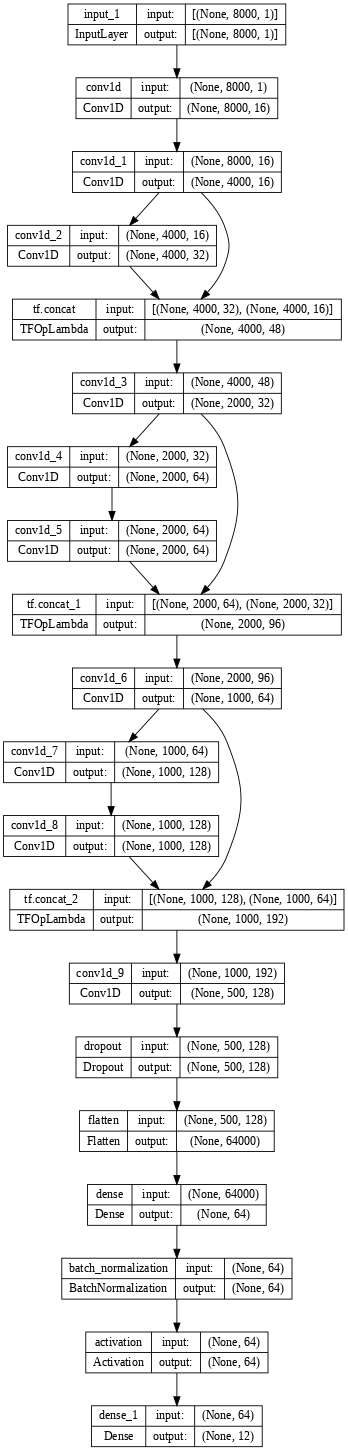

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

### Model training
* 모델 체크포인트로 저장공간을 확인 후 학습을 진행합니다.

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     monitor='val_loss',
                                                     restore_best_weights=True,
                                                     verbose=1)

In [ ]:
max_epochs = 100

cos_decay = tf.keras.experimental.CosineDecay(1e-4,
                                              max_epochs * 1.5)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [ ]:
# using `tf.data.Dataset`
# 학습을 이어 진행할때 필요한 부분이고, 이어 진핼할때 추가해주시면 됩니다.
# model.load_weights(checkpoint_dir)

history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[lr_callback, cp_callback, early_stopping_cb]
                    )


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/100
177/177 [==============================] - ETA: 0s - loss: 1.9917 - accuracy: 0.3203
Epoch 1: val_loss improved from inf to 2.23595, saving model to ./drive/My Drive/train_ckpt/wave/exp1
177/177 [==============================] - 90s 411ms/step - loss: 1.9917 - accuracy: 0.3203 - val_loss: 2.2360 - val_accuracy: 0.4116 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.998903260566294e-05.
Epoch 2/100
177/177 [==============================] - ETA: 0s - loss: 1.4739 - accuracy: 0.5407
Epoch 2: val_loss improved from 2.23595 to 1.69464, saving model to ./drive/My Drive/train_ckpt/wave/exp1
177/177 [==============================] - 73s 413ms/step - loss: 1.4739 - accuracy: 0.5407 - val_loss: 1.6946 - val_accuracy: 0.5444 - lr: 9.9989e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.995613800128922e-05.
Epoch 3/100
177/177 [==============================] - E

### 학습 결과 확인
* model fit의 return 값인 history에서 학습에 대한 결과를 확인해보자

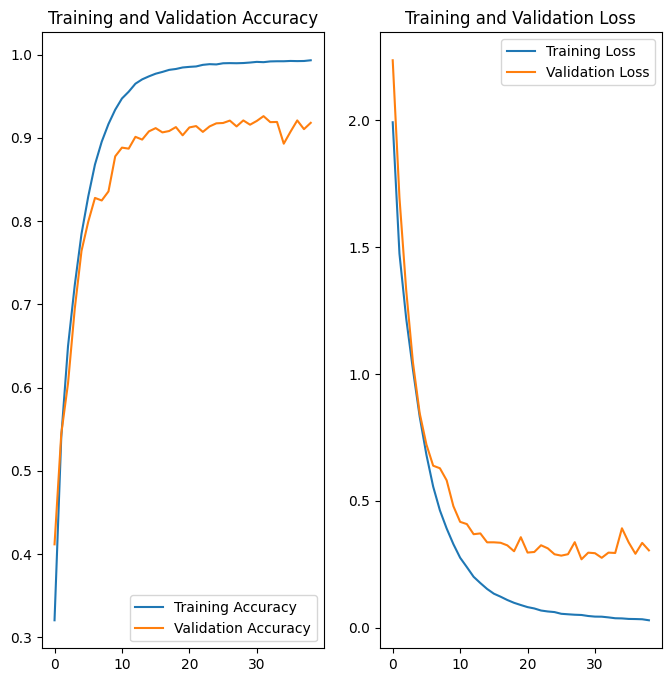

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation
* Test dataset을 이용해서 모델의 성능을 평가합니다.

In [ ]:
model.load_weights(checkpoint_dir)

In [ ]:
results = model.evaluate(test_dataset)

20/20 [==============================] - 5s 248ms/step - loss: 0.2724 - accuracy: 0.9206


### 스코어 결과
* 위의 스코어는 분류모델에 적용되는 스코어입니다.
* 모델의 크기 (MB) 와 정확도를 이용해 스코어를 출력합니다.

In [ ]:
def final_score():
    print("Model params num : " + str(model.count_params()))
    print("Accuracy : " + str(results[1]))

    s = (model.count_params() * 32) / (1024 ** 2)
    score = 50 * (results[1] + min((1/s), 1))

    print("score : " + str(score))

In [ ]:
final_score()

Model params num : 4671612
Accuracy : 0.9205847382545471
score : 46.379950970316045
